In [1]:
from omegaconf import OmegaConf
from diff_params.edm import EDM

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [103]:
config_path = "rep_training_config.yaml"
args = OmegaConf.load(config_path)
edm_sigmoid = EDM(args)
edm_sigmoid.schedule_type = 'sigmoid'
edm_cosine = EDM(args)
edm_cosine.schedule_type = 'cosine'
edm_power = EDM(args)
edm_power.schedule_type = 'power'

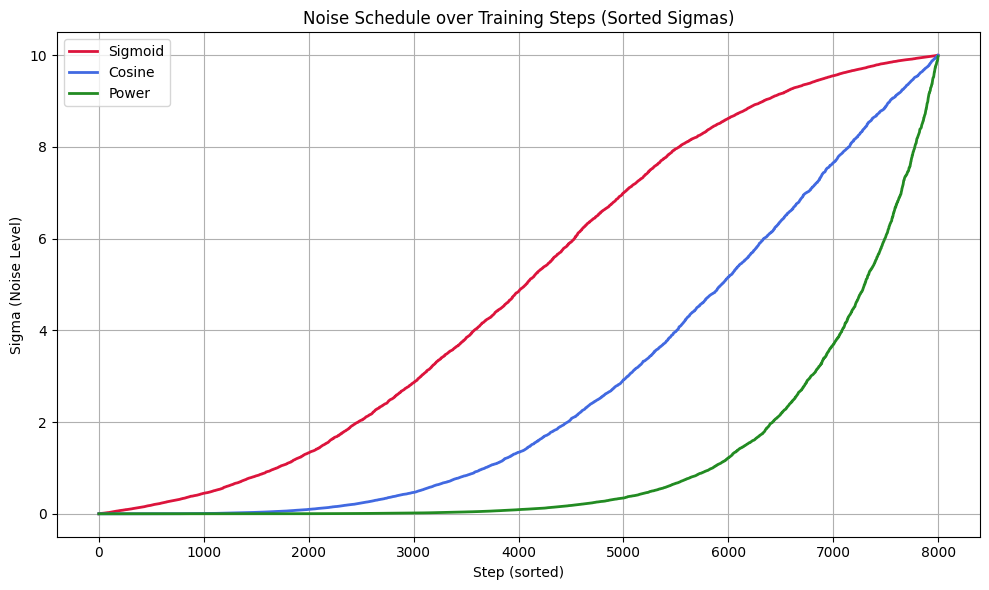

In [106]:
num_samples = 8000
sigmas_sigmoid = edm_sigmoid.sample_ptrain_safe(num_samples).cpu().numpy()
sigmas_cosine  = edm_cosine.sample_ptrain_safe(num_samples).cpu().numpy()
sigmas_power   = edm_power.sample_ptrain_safe(num_samples).cpu().numpy()

# Sort for visualization
sigmas_sigmoid_sorted = np.sort(sigmas_sigmoid)
sigmas_cosine_sorted  = np.sort(sigmas_cosine)
sigmas_power_sorted   = np.sort(sigmas_power)

# Plot all
plt.figure(figsize=(10, 6))
plt.plot(sigmas_sigmoid_sorted, label="Sigmoid", color="crimson", linewidth=2)
plt.plot(sigmas_cosine_sorted,  label="Cosine", color="royalblue", linewidth=2)
plt.plot(sigmas_power_sorted,   label="Power", color="forestgreen", linewidth=2)

plt.title("Noise Schedule over Training Steps (Sorted Sigmas)")
plt.xlabel("Step (sorted)")
plt.ylabel("Sigma (Noise Level)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [59]:
def smooth_curve(values, weight=0.9):
    values = np.array(values)
    if np.isnan(values).all():
        return np.zeros_like(values)
    values = np.nan_to_num(values, nan=np.nanmean(values))
    smoothed = []
    last = values[0]
    for val in values:
        last = weight * last + (1 - weight) * val
        smoothed.append(last)
    return smoothed

In [97]:
def plot_logsnr_evolution(
    csv_path,
    logsnr_col="logsnr",
    error_col="logsnr_error",
    step_col="step",
    title=None,
    save_path=None,
    bins=30,
    smooth_weight=0.9,
    normalize_range=(-10, 10),  # NEW: normalization range
):
    df = pd.read_csv(csv_path)

    # Normalize logSNR to [0, 1]
    min_val, max_val = normalize_range
    df["logsnr_normalized"] = (df[logsnr_col] - min_val) / (max_val - min_val)
    df["logsnr_normalized"] = df["logsnr_normalized"].clip(0, 1)

    max_step = df[step_col].max()
    df_early = df[df[step_col] < max_step / 3]
    df_mid = df[(df[step_col] >= max_step / 3) & (df[step_col] < 2 * max_step / 3)]
    df_late = df[df[step_col] >= 2 * max_step / 3]

    def _plot_split(df_split, label, color):
        bin_edges = np.linspace(0, 1, bins)
        df_split["logsnr_bin"] = pd.cut(df_split["logsnr_normalized"], bin_edges)
        grouped = df_split.groupby("logsnr_bin")[error_col].mean()
        grouped = grouped.dropna()
        bin_centers = [interval.mid for interval in grouped.index]
        smoothed = smooth_curve(grouped.values, weight=smooth_weight)
        plt.plot(bin_centers, smoothed, label=label, color=color)

    plt.figure(figsize=(9, 6))
    _plot_split(df_early, "Early", "green")
    _plot_split(df_mid, "Mid", "blue")
    _plot_split(df_late, "Late", "gold")
    plt.xlabel("Normalized logSNR (0 = low, 1 = high)")
    plt.ylabel("Avg Error")
    plt.title(title or "Error vs Normalized logSNR Over Training")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path)
        print(f"Plot saved to {save_path}")
    else:
        plt.show()

In [98]:
def plot_logsnr_evolution_unnormalized(
    csv_path,
    logsnr_col="logsnr",
    error_col="logsnr_error",
    step_col="step",
    title=None,
    save_path=None,
    bins=30,
    smooth_weight=0.95  # NEW: smoothing weight
):

    df = pd.read_csv(csv_path)

    max_step = df[step_col].max()
    df_early = df[df[step_col] < max_step / 3]
    df_mid = df[(df[step_col] >= max_step / 3) & (df[step_col] < 2 * max_step / 3)]
    df_late = df[df[step_col] >= 2 * max_step / 3]

    def _plot_split(df_split, label, color):
        bin_edges = np.linspace(df[logsnr_col].min(), df[logsnr_col].max(), bins)
        df_split["logsnr_bin"] = pd.cut(df_split[logsnr_col], bin_edges)
        grouped = df_split.groupby("logsnr_bin")[error_col].mean()
        bin_centers = [interval.mid for interval in grouped.index]

        # Smooth the curve
        smoothed = smooth_curve(grouped.values, weight=smooth_weight)
        plt.plot(bin_centers, smoothed, label=label, color=color)

    plt.figure(figsize=(9, 6))
    _plot_split(df_early, "Early", "green")
    _plot_split(df_mid, "Mid", "blue")
    _plot_split(df_late, "Late", "gold")
    plt.xlabel("logSNR")
    plt.ylabel("Avg Error")
    plt.title(title or "Error vs logSNR Over Training")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path)
        print(f"Plot saved to {save_path}")
    else:
        plt.show()

C:\Users\Yuri\AppData\Local\Temp\ipykernel_26756\2652509759.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_split["logsnr_bin"] = pd.cut(df_split["logsnr_normalized"], bin_edges)
C:\Users\Yuri\AppData\Local\Temp\ipykernel_26756\2652509759.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df_split.groupby("logsnr_bin")[error_col].mean()
C:\Users\Yuri\AppData\Local\Temp\ipykernel_26756\2652509759.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

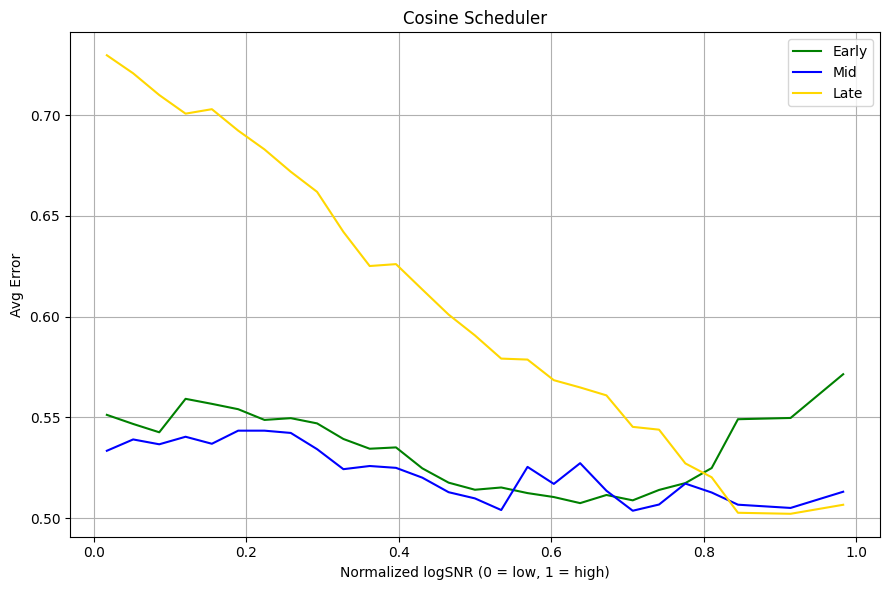

In [102]:
plot_logsnr_evolution("./logs/downloadedLogs/metrics_cosine_scheduler.csv", title="Cosine Scheduler", smooth_weight=0.95)

C:\Users\Yuri\AppData\Local\Temp\ipykernel_26756\3135075051.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_split["logsnr_bin"] = pd.cut(df_split[logsnr_col], bin_edges)
C:\Users\Yuri\AppData\Local\Temp\ipykernel_26756\3135075051.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df_split.groupby("logsnr_bin")[error_col].mean()
C:\Users\Yuri\AppData\Local\Temp\ipykernel_26756\3135075051.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

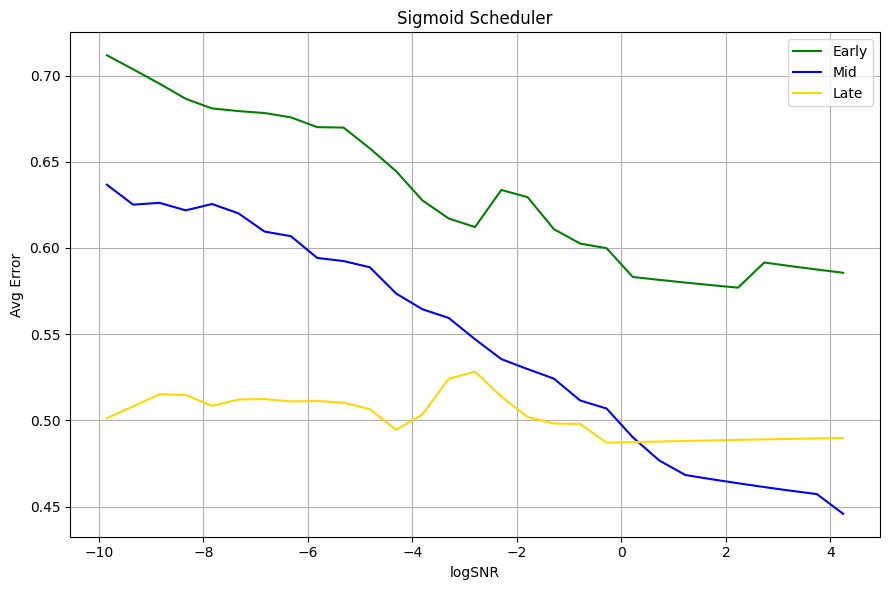

In [100]:
plot_logsnr_evolution_unnormalized("./logs/downloadedLogs/metrics_sigmoid_scheduler.csv", title="Sigmoid Scheduler")

C:\Users\Yuri\AppData\Local\Temp\ipykernel_26756\2652509759.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_split["logsnr_bin"] = pd.cut(df_split["logsnr_normalized"], bin_edges)
C:\Users\Yuri\AppData\Local\Temp\ipykernel_26756\2652509759.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df_split.groupby("logsnr_bin")[error_col].mean()
C:\Users\Yuri\AppData\Local\Temp\ipykernel_26756\2652509759.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

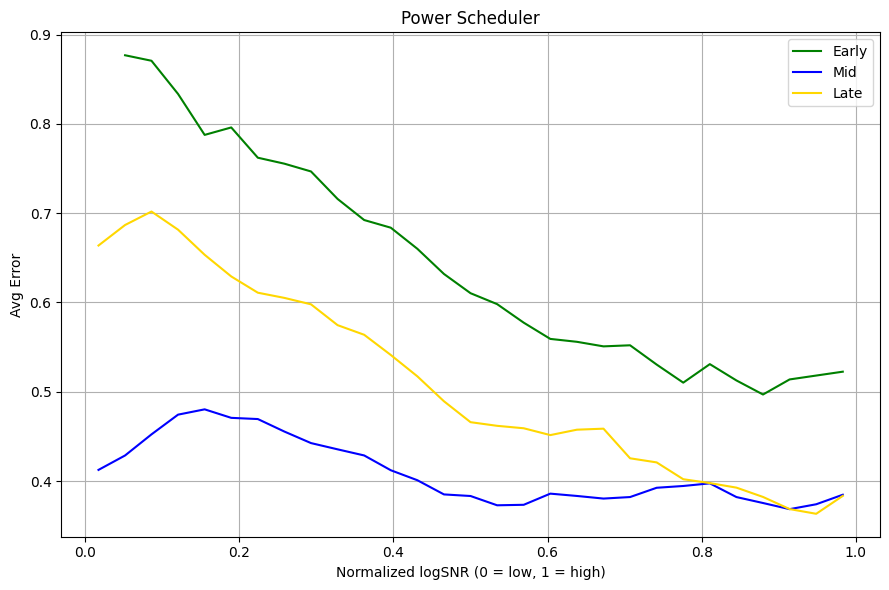

In [101]:
plot_logsnr_evolution("./logs/downloadedLogs/metrics_power_scheduler.csv", title="Power Scheduler")